<a href="https://colab.research.google.com/github/ML4SCI/DeepLearnHackathon/blob/main/ExoplanetSearchChallenge/Exoplanet_Search_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exoplanet Search Challenge

<div style="text-align: center;">
  <img src="https://upload.wikimedia.org/wikipedia/commons/9/9d/HL_Tau_protoplanetary_disk.jpg" alt="HL Tau" width="500" height="500">
</div>

Credit: ALMA (ESO/NAOJ/NRAO)


## Detecting Exoplanets in Protoplanetary Disks

### Description
Protoplanetary disks are the sites of planet formation. They provide laboratories against which theories of planet formation can be tested. State-of-the-art telescopes have the power to observe these systems in unprecedented detail. These observations can contain a wealth of information that can be used to advance theories. However, extracting this information can be difficult since the observations are noisy, and there are few well-understood disks. Recently, the interplay of advanced simulations and machine learning have been successful in analyzing these disks and identifying exoplanets [[1](https://ui.adsabs.harvard.edu/abs/2021ApJ...920....3A/abstract)] [[2](https://ui.adsabs.harvard.edu/abs/2022MNRAS.510.4473Z/abstract)] [[3](https://ui.adsabs.harvard.edu/abs/2022ApJ...941..192T/abstract)] [[4](https://ui.adsabs.harvard.edu/abs/2023ApJ...947...60T/abstract)]. This promising avenue of research is the basis for this Hackathon challenge.

### Task
The task is to train a model that is capable of identifying if a synthetic observation contains a planet. This is a binary classification problem: planet or no planet.

### Datasets
The data used was generated for [Terry et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022ApJ...941..192T/abstract). It consists of .fits files that represent synthetic continuum observations of protoplanetary disks at 1250 microns. Each simulation, for which there may be several snapshots, consists of a disk with between 0-4 planets. Data includes [the full training dataset](https://drive.google.com/drive/folders/1BV8FksW_EZnLTWUeHwJ_fEctFgjVbhMp?usp=drive_link), [a subset of the training data](https://drive.google.com/file/d/1I0JS1Qd896BGgsPcga3umQm-RuJB37UA/view?usp=drive_link), and [the training labels](https://drive.google.com/file/d/1gtBi4ILvCe8nTF09p_E9WWMplTQGC2Wr/view?usp=drive_link). The labels correspond to the simulation number, e.g., planet0_xxxx.fits corresponds to run 0. Each .fits file comes with 4 channels, but only the first one is relevant. This example only uses the small training subset since this is meant for speed and clarity rather than performance. Final training should be done on the entire training set.

### Evaluation Metrics
* AUC for withheld test set that will not be given
* Performance on real observations

## Deliverables
* You are required to submit a Google Colab Jupyter Notebook clearly showing your implementation along with the above-mentioned evaluation metrics for test data. This test data is part of the provided data, but it should not be used as training or validation data. It is not the same data that we will test on.
* A PDF of your final Jupyter notebook
* You must also submit the final trained model, including the model architecture and the trained weights ( For example: HDF5 file, .pb file, .pt file, etc. ) that can be easily implemented on our withheld data.


# Imports

In [1]:
# used for downloading data
!pip install gdown

In [2]:
# used for model
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 61.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [3]:
import os

from astropy.io import fits

import gdown

from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, progress
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

import torch
from torch import nn, Tensor
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader, Dataset, RandomSampler, random_split

import torchmetrics

import torchvision
import torchvision.transforms as T

In [4]:
torch.manual_seed(123)
np.random.seed(123)

# Load data

The below method downloads the data from Google Drive. This will be very slow for when using the entire dataset, so it is recommended that the data is added to your personal Google Drive and mount it using code similar to that below (or do it locally)

```python
from google.colab import drive
drive.mount("/content/drive")
data_dir = "/content/drive/My Drive/Full_Train_Data/"
data_names = os.listdir(data_dir)
label_name = "/content/drive/My Drive/train_info.csv"
label_df = pd.read_csv(label_name, usecols=range(1, 11))
```

In [5]:
### Sample data subset (NOT full dataset)
### The dataset used in this example is a very small subset for the sake of speed
### Using only this data would severely overtrain the models
### For deployment, the entire training data folder should be used
# data_id = "15AMGfgEu2ltGZN3rVtMV97mSbF2USrs6" ## for full set
data_id = "1I0JS1Qd896BGgsPcga3umQm-RuJB37UA"
gdown.download(f"https://drive.google.com/uc?id={data_id}", "data_names.zip", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1I0JS1Qd896BGgsPcga3umQm-RuJB37UA
From (redirected): https://drive.google.com/uc?id=1I0JS1Qd896BGgsPcga3umQm-RuJB37UA&confirm=t&uuid=9f8a5bf1-9493-4a4a-ade6-43a21d1be411
To: /content/data_names.zip
100%|██████████| 366M/366M [00:02<00:00, 171MB/s]


'data_names.zip'

In [6]:
# unzip the downloaded data folder
!unzip -q data_names.zip -d data_names

In [7]:
# load fits files
data_dir = "data_names/Sample_Data/" ### Not full dataset
# data_dir = "data_names/Full_Train_Data/" ### Full dataset
data_names = os.listdir(data_dir)
# make sure there aren't any weird files in the folder
data_names = np.array([x for x in data_names if ".fits" in x])

In [8]:
# get run information
run_nums = np.array([int(x.split("planet")[1].split("_")[0]) for x in data_names])

In [9]:
# sort by run number
order = np.argsort(run_nums)
run_nums = run_nums[order]
data_names = data_names[order]

In [10]:
# Download labels
label_id = "1gtBi4ILvCe8nTF09p_E9WWMplTQGC2Wr"
gdown.download(f"https://drive.google.com/uc?id={label_id}", "label_name.csv", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1gtBi4ILvCe8nTF09p_E9WWMplTQGC2Wr
To: /content/label_name.csv
100%|██████████| 48.7k/48.7k [00:00<00:00, 35.3MB/s]


'label_name.csv'

In [11]:
# Load labels
label_name = "label_name.csv"
label_df = pd.read_csv(label_name, usecols=range(1, 11))
label_df.head()
# (run, number of planets, mass of planet 1, semimajor axis of planet 1, ....)

,run,n,m1,r1,m2,r2,m3,r3,m4,r4
0,0.0,3.0,0.001738,17.433073,0.004807,56.217795,0.001016,66.676827,0.000000,0.000000
1,1.0,4.0,0.000359,64.147071,0.000192,100.943570,0.000016,118.540489,0.000497,134.070028
2,2.0,3.0,0.000639,54.386533,0.000672,92.352140,0.002246,152.530577,0.000000,0.000000
3,3.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4.0,4.0,0.000053,24.550451,0.000327,35.877340,0.000114,40.213780,0.000283,122.145050


In [12]:
runs = label_df.run.to_numpy()
Ns = label_df.n.to_numpy()

In [13]:
# label whether it's a planet or not a planet
labels = {}
nums = {}
for (name, run) in zip(data_names, run_nums):
    label = Ns[np.where(runs == run)][0]
    nums[name] = int(label)
    labels[name] = int(label > 0)

In [14]:
# Get actual data
data = {}
for name in data_names:
    # There are 4 channels, but we only care about the first
    data[name] = fits.open(f"{data_dir}{name}")[0].data.squeeze()[0]
    # normalize
    data[name] -= np.min(data[name])
    data[name] /= np.max(data[name])

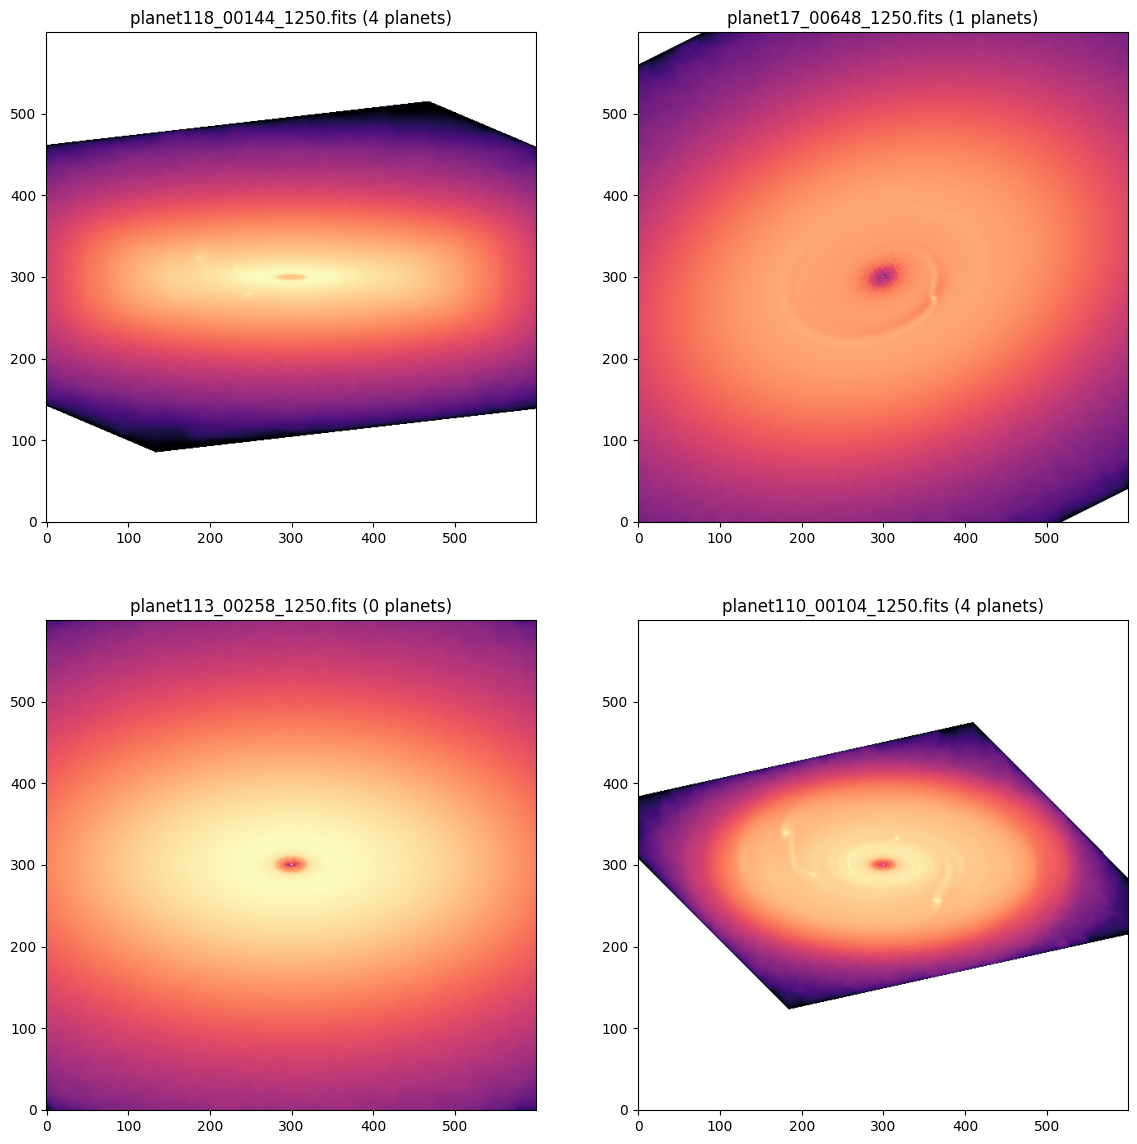

In [15]:
# show some data
# some of the data has zero values due to the orientation
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=((14, 14)))

img_index = np.random.randint(0, len(data_names), size=4)

axs[0, 0].imshow(data[data_names[img_index[0]]],
          origin="lower",
          cmap="magma",
          norm=LogNorm(vmin=1e-6, vmax=1),
          )
axs[0, 1].imshow(data[data_names[img_index[1]]],
          origin="lower",
          cmap="magma",
          norm=LogNorm(vmin=1e-6, vmax=1),
          )
axs[1, 0].imshow(data[data_names[img_index[2]]],
          origin="lower",
          cmap="magma",
          norm=LogNorm(vmin=1e-6, vmax=1),
          )
axs[1, 1].imshow(data[data_names[img_index[3]]],
          origin="lower",
          cmap="magma",
          norm=LogNorm(vmin=1e-6, vmax=1),
          )

axs[0, 0].set_title(f"{data_names[img_index[0]]} ({nums[data_names[img_index[0]]]} planets)")
axs[0, 1].set_title(f"{data_names[img_index[1]]} ({nums[data_names[img_index[1]]]} planets)")
axs[1, 0].set_title(f"{data_names[img_index[2]]} ({nums[data_names[img_index[2]]]} planets)")
axs[1, 1].set_title(f"{data_names[img_index[3]]} ({nums[data_names[img_index[3]]]} planets)")

plt.show()

In [16]:
xy_dim = data[data_names[0]].shape[0]

In [17]:
# Initialize the data arrays
X = np.empty((len(data_names), xy_dim, xy_dim))
y = np.empty((len(data_names), 1))

In [18]:
# load images and labels
for i, name in enumerate(data_names):
    X[i, :, :] = data[name]
    y[i, 0] = labels[name]
# add a channel axis
X = X[:, np.newaxis, :, :]

In [19]:
X = X.astype(np.float32)
y = y.astype(np.float32)

In [20]:
# split into train/test/val
##### Report the AUC of the created test data
test_split = 0.2
val_split = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_split)

# Make datasets/loaders

In [21]:
class DiskDataset(Dataset):

    """Data loader"""

    def __init__(
        self,
        X: np.ndarray,
        y: np.ndarray,
        transform: list = None,
        accelerator_name: str = "mps",
    ) -> None:

        self.X = X
        self.y = y
        self.transform = transform

        if accelerator_name == "mps":
            self.device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
        elif accelerator_name == "cuda:0":
            self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx) -> torch.Tensor:
        x_, y_ = self.X[idx], self.y[idx]

        x_, y_ = torch.from_numpy(x_),\
                torch.from_numpy(y_)

        if self.transform:
            x_ = self.transform(x_)
        return x_.to(self.device), y_.to(self.device)

In [22]:
# need to resize for EffnetV2
input_size = 224
transform = T.Compose([
                        T.Resize((input_size, input_size), antialias=True),
                        T.Normalize(mean=[0.5], std=[0.5]),
])

In [23]:
##### Now we actually make the dataset and dataloader in PyTorch fashion
train_data = DiskDataset(X_train, y_train, transform=transform)
val_data = DiskDataset(X_val, y_val, transform=transform)
test_data = DiskDataset(X_test, y_test, transform=transform)

In [24]:
# this is artificially small due to the tiny amount of data in this example
batch_size = 16

# make the loader
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

# Make model

This model is a simple implementation of torchvision's EfficientNetV2

In [25]:
class CustomEfficientNetV2(pl.LightningModule):
    def __init__(self,
                 num_channels: int = 1,
                 num_outputs: int = 1,
                 lr: float = 5e-4,
                 xy_dim: int = 224,
                ):
        super().__init__()
        self.save_hyperparameters()

        # Load EfficientNetV2 model
        self.model = torchvision.models.efficientnet_v2_s()

        # Modify the first convolutional layer if input channels are different from 3
        if num_channels != 3:
            self.model.features[0][0] = nn.Conv2d(num_channels,
                                                  self.model.features[0][0].out_channels,
                                                  kernel_size=self.model.features[0][0].kernel_size,
                                                  stride=self.model.features[0][0].stride,
                                                  padding=self.model.features[0][0].padding,
                                                  bias=False,
                                                 )

        # Modify the final fully connected layer
        in_features = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Linear(in_features, num_outputs)

        self.criterion = nn.BCEWithLogitsLoss()

        # Initialize containers to store outputs
        self.validation_outputs = []
        self.test_outputs = []

        self.example_input_array = torch.randn((1, num_channels, xy_dim, xy_dim)).float()

    def forward(self, x):
        return self.model(x)

    def _process_batch(self, batch, when: str = "train"):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log(f"{when}_loss", loss)
        if when != "train":
            return {f"{when}_loss": loss, "y_hat": y_hat, "y": y}
        return loss

    def training_step(self, batch, batch_idx):
        return self._process_batch(batch, when="train")

    def validation_step(self, batch, batch_idx):
        outputs = self._process_batch(batch, when="val")
        self.validation_outputs.append(outputs)
        return outputs

    def test_step(self, batch, batch_idx):
        outputs = self._process_batch(batch, when="test")
        self.test_outputs.append(outputs)
        return outputs

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(),
                                lr=self.hparams.lr,
                               )

    def _roc_epoch_end(self, outputs, when: str = "val"):
        """Logs AUC during validation/testing"""
        y_hat = torch.cat([x["y_hat"] for x in outputs]).detach().cpu().numpy()
        y = torch.cat([x["y"] for x in outputs]).detach().cpu().numpy()
        auc = self.calculate_auc(y_hat, y)
        self.log(f"{when}_auc", auc)

    def on_validation_epoch_end(self,):
        self._roc_epoch_end(self.validation_outputs, when="val")
        self.validation_outputs.clear()

    def on_test_epoch_end(self,):
        self._roc_epoch_end(self.test_outputs, when="test")
        self.test_outputs.clear()

    def calculate_auc(self, y_hat, y):
        # Apply sigmoid to predictions if using BCEWithLogitsLoss
        y_hat = torch.sigmoid(torch.tensor(y_hat).float()).numpy()
        auc = roc_auc_score(y, y_hat)
        return auc.astype(np.float32)


In [26]:
model = CustomEfficientNetV2()

# Train

Full deployment will take a long time if GPUs aren't used.

In [27]:
accelerator_name = "cuda:0"

if accelerator_name == "mps":
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
elif accelerator_name == "cuda:0":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

In [28]:
#### necessary for newer PTL versions
devices = 1
accelerator = "gpu" if devices == 1 else "cpu"

In [29]:
#### This is artificially small for the purposes of speed
num_epochs = 5
# make the trainer
trainer = pl.Trainer(
    devices=devices,
    accelerator=accelerator,
    max_epochs=num_epochs,
    log_every_n_steps=1,
    callbacks=[
        LearningRateMonitor("epoch"),
        progress.TQDMProgressBar(refresh_rate=1),
        EarlyStopping(
            monitor="val_auc",
            min_delta=0,
            patience=20,
            verbose=False,
            mode="min",
        ),
    ],
)
trainer.logger._log_graph = True
trainer.logger._default_hp_metric = None

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [30]:
model = model.to(device)

# fit the model
trainer.fit(
    model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode  | In sizes         | Out sizes
---------------------------------------------------------------------------------------
0 | model     | EfficientNet      | 20.2 M | train | [1, 1, 224, 224] | [1, 1]   
1 | criterion | BCEWithLogitsLoss | 0      | train | ?                | ?        
---------------------------------------------------------------------------------------
20.2 M    Trainable params
0         Non-trainable params
20.2 M    Total params
80.713    Total estimated model params size (MB)
715       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


# Test

This is the AUC that will be judged, i.e., provided data that isn't used in training.

In [31]:
model.eval()
print("Testing model")

Testing model


In [32]:
# Make a dataloader for the test data
test_batch_size = 16
test_loader = DataLoader(test_data, batch_size=test_batch_size)

In [33]:
# do inference on all test batches
results = []

for X_batch in test_loader:
    X_batch = X_batch[0]  # DataLoader returns a tuple
    with torch.no_grad():
        outputs = torch.sigmoid(model(X_batch))
    batch_results = outputs.detach().numpy().squeeze()
    results.append(batch_results)

y_pred = np.concatenate(results, axis=0)

In [34]:
# get ROC curve/AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
accuracy = np.sum([round(y_pred[i]) == y_test[i] for i in range(len(y_test))]) / len(y_test)

print(f"Accuracy of {accuracy:.2}. AUC of {auc}")

Accuracy of 0.75. AUC of 0.7291666666666667


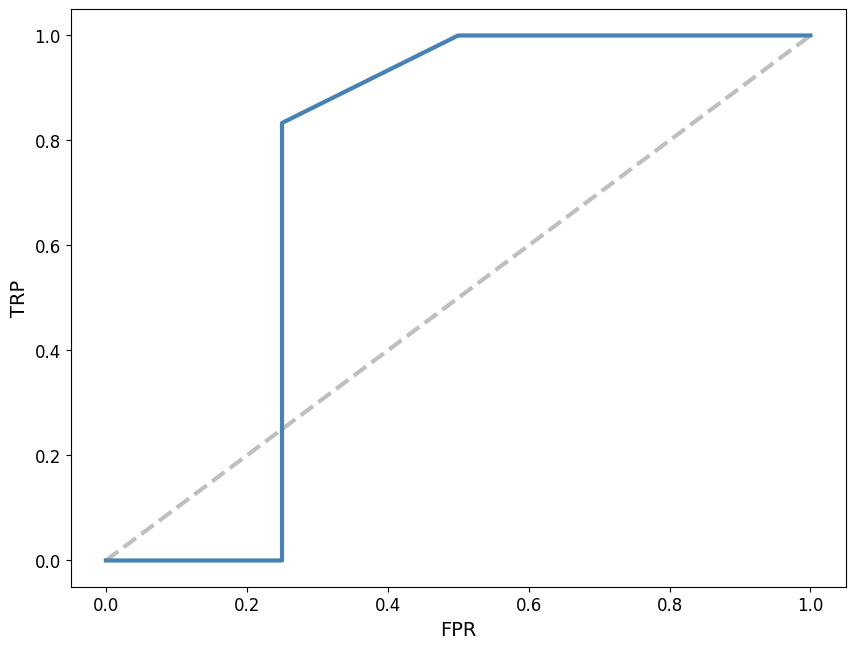

In [35]:
# Plot ROC curve
plt.figure(figsize=(10., 7.5))

plt.plot(fpr, tpr, lw=3, c="steelblue")
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100),
         c="gray", ls="--", alpha=0.5, lw=3,
         )

plt.xlabel("FPR", fontsize=14)
plt.ylabel("TRP", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()